In [1]:
import torch
import numpy as np

from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from neuralop.models import FNO

/var/folders/0g/6p58411j1tv6772_j1kq_lkh0000gn/T/ipykernel_33003/1489379104.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, modes, input_dim, hidden_dim, model_dim, bidirectional=False, with_t=False):
        
        super().__init__()
        self.with_t = with_t
        self.bidirectional = bidirectional
        if self.with_t:
            input_dim += 1

        
        self.forward_encoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=2*hidden_dim, hidden_channels=model_dim)
        if self.bidirectional:
            self.backward_encoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=2*hidden_dim, hidden_channels=model_dim)
    def forward(self, x, t=None):
        if t:
            x = torch.concatenate([x, t], dim=1)
        
        mu, log_var = torch.chunk(self.forward_encoder(x), chunks=2, dim=1)

        if self.bidirectional:
            mu_backward, log_var_backward = torch.chunk(self.backward_encoder(torch.flip(x, dims=(1,))), chunks=2, dim=1)
            mu = torch.concat([mu, mu_backward], dim=1)
            log_var = torch.concat([log_var, log_var_backward], dim=1)
    
        return mu, log_var
    
    def sample_posterior(self, mu, log_var):
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std
    
    def log_prob(self, z, mu, log_var):
        var = torch.exp(log_var)

        log_prob = -0.5 * (torch.log(2*torch.pi* var) + ((z-mu)**2)/var)

        return log_prob.sum(dim=1)


In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, modes, input_dim, hidden_dim, model_dim, with_t=False):
        
        super().__init__()
        self.with_t = with_t

        if self.with_t:
            input_dim += 1

        self.decoder = FNO(n_modes=modes, in_channels=input_dim, out_channels=hidden_dim, hidden_channels=model_dim)

    def forward(self, z, t=None):

        if self.with_t and not t:
            raise ValueError("t is missing as an input but `with_t` is True which will cause shape errors!")
        elif self.with_t and t:
            z = torch.concatenate([z, t], dim=1)
        else:
            pass
        
        x_hat = self.decoder(z)

        return x_hat
    
    

In [5]:
class NOVAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_modes, encoder_size, decoder_modes, decoder_size, bidirectional=False, prior_mean=0.0, prior_std = 1.0, beta=1.0, with_t = False,
                 use_dynamics=False, dynamics_modes=(16,), dynamics_size=16, dynamics_steps=1):
        super().__init__()

        self.beta = beta
        self.prior_mean = torch.tensor(prior_mean)
        self.prior_std = torch.tensor(prior_std)
        self.use_dynamics = use_dynamics
        self.dynamics_steps = dynamics_steps
        self.bidirectional = bidirectional

        # Encoder FNO: maps (x(t)) -> hidden features
        self.encoder = Encoder(encoder_modes, input_dim, latent_dim, encoder_size, bidirectional, with_t)

        self.decoder = Decoder(decoder_modes, 
                               2 * latent_dim if bidirectional else latent_dim,
                               input_dim, 
                               decoder_size, with_t)

        # Optional dynamics model in latent space
        if self.use_dynamics:
            self.dynamics_model = FNO(n_modes=dynamics_modes, in_channels=latent_dim, out_channels=latent_dim, hidden_channels=dynamics_size)

    def forward(self, x, t_coords=None):
        # x: (batch, time, input_dim)
        # t_coords: (batch, time, 1)

        mu, logvar = self.encoder(x, t_coords)

        z = self.encoder.sample_posterior(mu, logvar)

        if self.use_dynamics:
            z_dyn = z
            for _ in range(self.dynamics_steps):
                z_dyn = self.dynamics_model(z_dyn)
            z = z_dyn

        x_hat = self.decoder(z, t_coords)

        return x_hat, mu, logvar

    def compute_loss(self, x_hat, x, mu, logvar):
        recon_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='mean')
        var = torch.exp(logvar)
        prior_var = self.prior_std ** 2
        prior_mean = self.prior_mean

        kl_loss = 0.5 * torch.mean(
            (var + (mu - prior_mean) ** 2) / prior_var - 1 + torch.log(prior_var) - logvar
        )
        elbo = recon_loss + self.beta * kl_loss
        return {"elbo": elbo, "reconstruction": recon_loss, "kl": kl_loss}

In [6]:
model = NOVAE(128, 32, (16, ), 64, (16, ), 64, 0, 3)

In [7]:
x = torch.randn(1,128,32)
x_hat, mu, logvar = model(x)
x_hat.shape, mu.shape, logvar.shape

(torch.Size([1, 128, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]))

In [8]:
model.compute_loss(x_hat, x, mu, logvar)

{'elbo': tensor(5.4828, grad_fn=<AddBackward0>),
 'reconstruction': tensor(1.0020, grad_fn=<MseLossBackward0>),
 'kl': tensor(4.4808, grad_fn=<MulBackward0>)}

In [9]:
# True decoder: a small MLP
class MLP(torch.nn.Module):
    def __init__(self, input_dim, projection_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, projection_dim)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, input_dim=3, projection_dim=10, nonlinear=False):
        super().__init__()
        if nonlinear:
            self.net = torch.nn.Sequential(
                torch.nn.Conv1d(input_dim, 64, kernel_size=1),
                torch.nn.ReLU(),
                torch.nn.Conv1d(64, projection_dim, kernel_size=1)
            )
        else:
            self.net = torch.nn.Conv1d(input_dim, projection_dim, kernel_size=1, bias=False)

    def forward(self, x):
        # x: (B, 3, T) → output: (B, D, T)
        return self.net(x)

In [11]:
# === Step 1: Simulate the Lorenz Attractor ===
def lorenz_deriv(state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state.squeeze()
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return torch.stack([dx, dy, dz]).unsqueeze(0)

def simulate_lorenz(x0, dt=0.01, steps=10000, device="cpu"):
    traj = torch.zeros((steps, 3), device=device)
    state = x0
    for i in range(steps):
        deriv = lorenz_deriv(state)
        state = state + dt * deriv
        traj[i] = state
    return traj

def plot_lorenz(x=None, z=None, x_hat=None, z_hat=None):

    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(z, torch.Tensor):
        z = z.detach().cpu().numpy()
    if isinstance(x_hat, torch.Tensor):
        x_hat = x_hat.detach().cpu().numpy()
    if isinstance(z_hat, torch.Tensor):
        z_hat = z_hat.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(12, 5))
    # Original Lorenz

    if z is not None or z_hat is not None:
        ax1 = fig.add_subplot(121, projection='3d', )

    if z is not None:
        if z_hat is not None:
            ls = "--"
        else:
            ls = "-"
        ax1.plot(*z, lw=0.5, label=r"$z$", ls=ls)
        ax1.set_title("Lorenz Attractor (3D)")
        ax1.legend()
    if z_hat is not None:
        ax1.plot(*z_hat, lw=0.5, label=r"$\hat{z}$")
        ax1.legend()

    if x is not None or x_hat is not None:
        ax2 = fig.add_subplot(122, projection='3d')

    if x is not None:
        if x_hat is not None:
            ls = "--"
        else:
            ls = "-"
        ax2.plot(*x[:3,:], lw=0.5, label=r"$x$",ls=ls)
        ax2.set_title("Embedded Trajectory (first 3 dims)")
        ax2.legend()
    if x_hat is not None:
        ax2.plot(*x_hat[:3,:], lw=0.5, label=r"$\hat{x}$")
        ax2.legend()
        
    plt.tight_layout()
    plt.show()


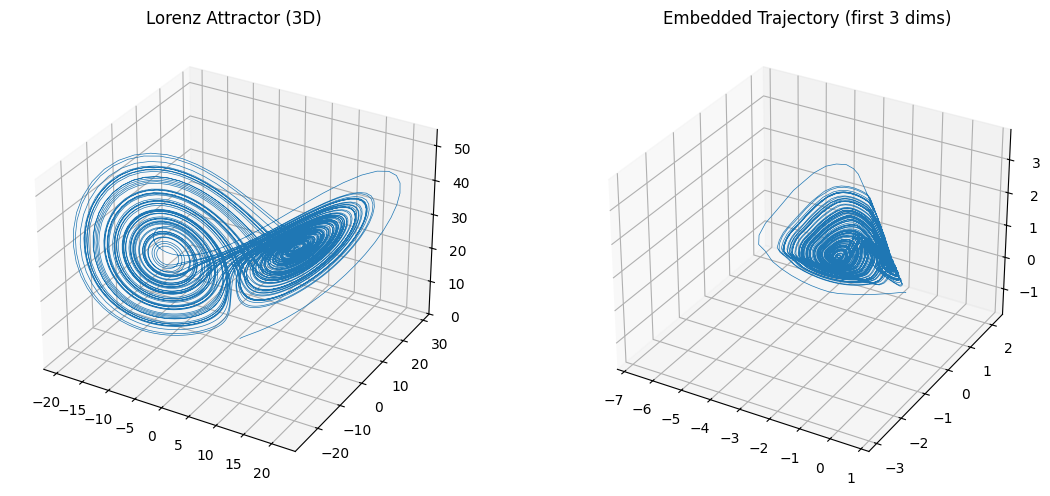

torch.Size([10000, 3])

In [12]:

# Initial condition
x0 = torch.tensor([1.0, 1.0, 1.0])
trajectory = simulate_lorenz(x0)

embedder = MLP(3, 10)
with torch.no_grad():
    embedded_trajectory = embedder(trajectory)

# === Step 3: Optional: Visualize original vs projected ===

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 5))

# Original Lorenz
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*trajectory.cpu().T, lw=0.5)
ax1.set_title("Lorenz Attractor (3D)")

# Projected to first 3 dims of higher space
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*embedded_trajectory[:, :3].cpu().T, lw=0.5)
ax2.set_title("Embedded Trajectory (first 3 dims)")

plt.tight_layout()
plt.show()
trajectory.shape


In [13]:

class EmbeddedLorenzDataset(torch.utils.data.Dataset):
    def __init__(self, traj_file=None, num_samples=500, steps=1000, dt=0.01, embed_dim=10, window_size=100, stride=100, nonlinear=False, x0=None, device="cpu", normalize=True):
        self.dt = dt
        self.embedder = CNN(input_dim=3, projection_dim=embed_dim, nonlinear=nonlinear)
        self.x0 = x0
        self.device = device
        self.normalize = normalize

        if traj_file is not None and traj_file != "":

            print("Loading traj file")
            self.traj_file = torch.load(traj_file)
            print("loading lorenz")
            self.sample_trajectories = self.traj_file["traj"]
            print("loading embedded lorenz")
            self.sample_embedded_trajectories = self.traj_file["embed_traj"]
            print("data loaded")
            #self.sample_x0 = self.traj_file["x0"] 
            
            self.num_samples, _, self.steps = self.traj_file["traj"].shape
        else:
            self.traj_file = None
            self.num_samples = num_samples
            self.steps = steps
            self.sample_trajectories = torch.zeros(num_samples, 3, steps)
            self.sample_embedded_trajectories = torch.zeros(num_samples, embed_dim, steps)

            if self.x0 is not None:
                self.sample_x0 = self.x0.repeat(num_samples, 1)
            else:
                self.sample_x0 = torch.zeros(num_samples, 3)
                
            for i in tqdm(range(num_samples)):
                sample_trajectory, sample_x0 = self.generate_trajectory(self.x0, self.dt, self.steps, self.normalize)
                self.sample_trajectories[i, :, :] = sample_trajectory.T
                self.sample_x0[i,:] = sample_x0

                embedded_trajectory = self.embed_trajectory(sample_trajectory)
                self.sample_embedded_trajectories[i,:,:] = embedded_trajectory

        self.window = min(self.steps, window_size)
        self.stride = stride
        self.n_windows = (((self.steps - self.window) // self.stride) + 1)

    def __len__(self):
        return self.num_samples * self.n_windows

    def generate_trajectory(self, x0=None, dt=0.01, steps=1000, normalize=True):
        x0 = None
        if x0 is None:
            x0 = torch.rand(3) * 30.0 - 15.0

        traj  = simulate_lorenz(x0, dt = dt, steps=steps)

        if normalize:
            traj = traj / torch.linalg.norm(traj, dim=0, keepdim=True)

        return traj, x0
    
    def embed_trajectory(self, traj):
        if isinstance(self.embedder, CNN):
            traj = traj.T

        with torch.no_grad():
            embedded_trajectory = self.embedder(traj)  # (B, D, T)

        if isinstance(self.embedder, MLP):
            embedded_trajectory = embedded_trajectory.T
            
        return embedded_trajectory

    def window_indices(self, idx):
        window_idx = idx % self.n_windows
        start = window_idx * self.stride
        stop = start + self.window
        return max(0, start), min(stop, self.steps)
    def __getitem__(self, idx):
        sample_idx = idx // self.num_samples
        start, stop = self.window_indices(idx)
        embed_traj = self.sample_embedded_trajectories[sample_idx,:,start:stop]
        traj = self.sample_trajectories[sample_idx,:,start:stop]

        return embed_traj, traj

        

        # Embed to higher dimensions

In [14]:
ds = EmbeddedLorenzDataset(traj_file="lorenz13k.pt",steps=10000, x0=None, nonlinear=True)
len(ds)

Loading traj file
loading lorenz
loading embedded lorenz
data loaded


1280000

In [15]:

x, z = ds[0]
x.shape, z.shape

(torch.Size([128, 100]), torch.Size([3, 100]))

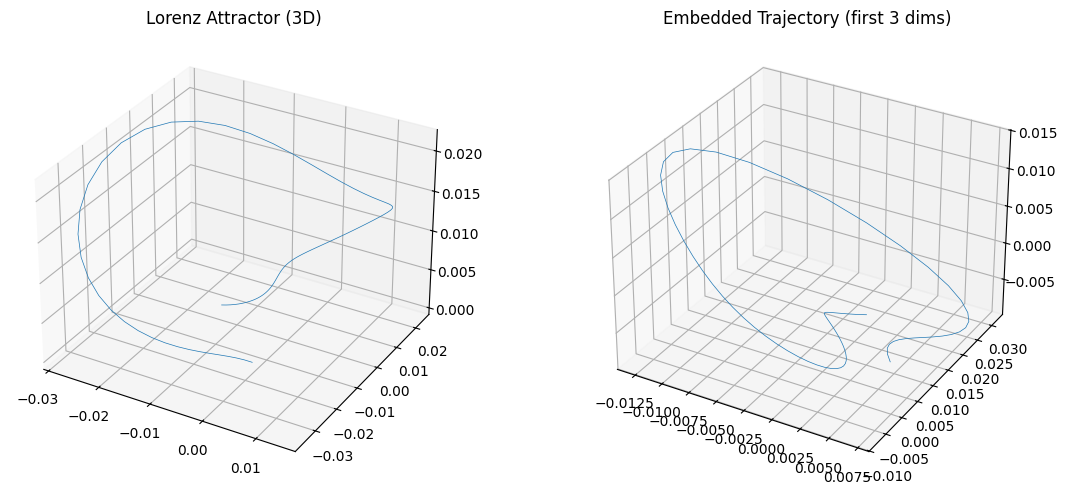

torch.Size([10000, 3])

In [16]:
fig = plt.figure(figsize=(12, 5))

# Original Lorenz
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*z.cpu(), lw=0.5)
ax1.set_title("Lorenz Attractor (3D)")

# Projected to first 3 dims of higher space
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*x[:3,:].cpu(), lw=0.5)
ax2.set_title("Embedded Trajectory (first 3 dims)")

plt.tight_layout()
plt.show()
trajectory.shape


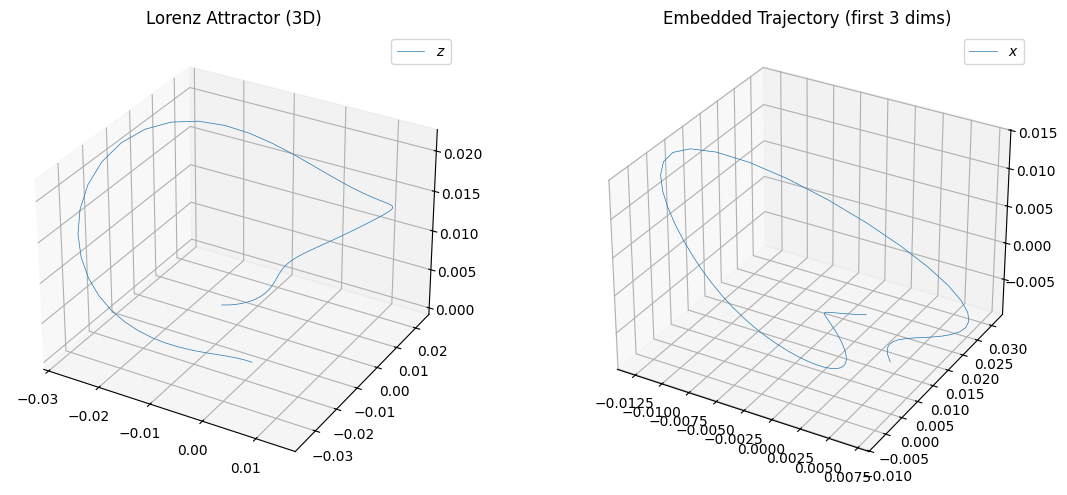

In [17]:
plot_lorenz(x, z)

In [18]:

def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L    


def frange_cycle_sigmoid(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # step is in [0,1]
    
    # transform into [-6, 6] for plots: v*12.-6.

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop:
            L[int(i+c*period)] = 1.0/(1.0+ np.exp(- (v*12.-6.)))
            v += step
            i += 1
    return L    


#  function  = 1 − cos(a), where a scans from 0 to pi/2

def frange_cycle_cosine(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # step is in [0,1]
    
    # transform into [0, pi] for plots: 

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop:
            L[int(i+c*period)] = 0.5-.5*np.cos(v*np.pi)
            v += step
            i += 1
    return L    

def frange(start, stop, step, n_epoch):
    L = np.ones(n_epoch)
    v , i = start , 0
    while v <= stop:
        L[i] = v
        v += step
        i += 1
    return L

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28,
       0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72,
       0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 0.  , 0.04, 0.08, 0.12, 0.16,
       0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 ,
       0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 0.  , 0.04,
       0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48,
       0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92,
       0.96])

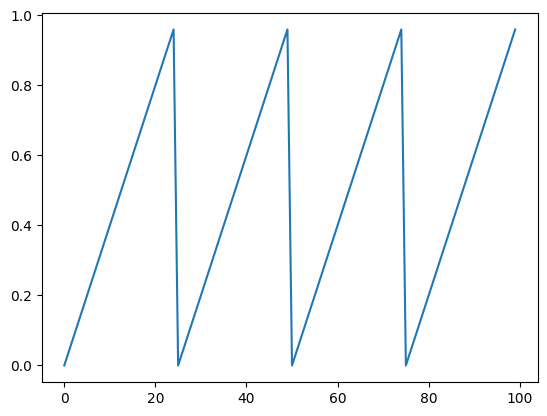

In [ ]:
betas = frange_cycle_linear(0, 1, n_epoch=100, n_cycle=4, ratio=0.5)
plt.plot(betas)
betas


In [87]:
n_epochs = 100
batch_size = 128
dataset_size = batch_size * 100
latent_dim = 3
projection_dim = 128
betas = betas
prior_std = np.sqrt(1)

#ds = EmbeddedLorenzDataset(num_samples=dataset_size, steps=10000, dt=0.01, embed_dim=projection_dim, device=device)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)


In [88]:
model = NOVAE(projection_dim, latent_dim, (16,), 64, (16,), 64, beta=betas[0], prior_std=prior_std)
model.to(device)

optimizer = torch.optim.Adam(model.parameters())

per_epoch_loss = {"elbo":[], "kl": [], "reconstruction": []}
per_batch_loss = {"elbo":[], "kl": [], "reconstruction": []}

epoch_progress_bar = tqdm(range(n_epochs), desc="epochs")
for i in epoch_progress_bar:

    batch_progress_bar = tqdm(enumerate(dl), desc="batches", total=len(dl), nrows=1, position=1, leave=True)
    for j, batch in batch_progress_bar:
        x, z_true = batch
        x = x[:,:,::50].to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = model.compute_loss(x_hat, x, mu, logvar)

        loss["elbo"].backward()
        optimizer.step()

        per_batch_loss["elbo"].append(loss["elbo"].item())
        per_batch_loss["kl"].append(loss["kl"].item())
        per_batch_loss["reconstruction"].append(loss["reconstruction"].item())

        batch_progress_bar.set_postfix({key: val.item() for key, val in loss.items()})

    per_epoch_loss["elbo"].append(np.mean(per_batch_loss["elbo"]))
    per_epoch_loss["kl"].append(np.mean(per_batch_loss["kl"]))
    per_epoch_loss["reconstruction"].append(np.mean(per_batch_loss["reconstruction"]))

    desc = {key: np.mean(val) for key, val in per_batch_loss.items()}
    desc["beta"] = model.beta
    epoch_progress_bar.set_postfix(desc)

    per_batch_loss["elbo"] = []
    per_batch_loss["kl"] = []
    per_batch_loss["reconstruction"] = []

    
    
    model.beta = betas[i]

    


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/10000 [00:00<?, ?it/s]

batches:   0%|          | 0/10000 [00:00<?, ?it/s]

batches:   0%|          | 0/10000 [00:00<?, ?it/s]

batches:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

2267


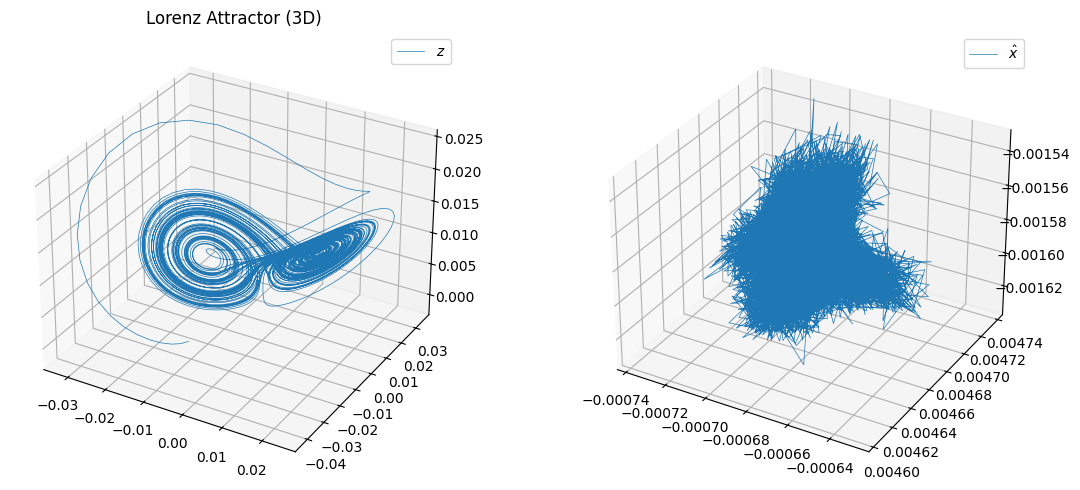

(torch.Size([3, 10000]), torch.Size([128, 10000]))

In [92]:
model.eval()
x_full, z_full = [], []
x_hat_full, z_hat_full = [], []
mu_full, logvar_full = [], []
sample_idx = np.random.choice(np.arange(ds.num_samples))

with torch.no_grad():
    for j in range(sample_idx*ds.n_windows, sample_idx * ds.n_windows + ds.n_windows):
        x, z_true = ds[j]
        x_full.append(x)
        z_full.append(z_true)

        x = x.to(device)
        mu, logvar = model.encoder(x.unsqueeze(0))
        mu_full.append(mu)
        logvar_full.append(logvar)

        #print(mu.mean(), logvar.mean().exp())
        z_samples = []
        for i in range(10):
            z_samples.append(model.encoder.sample_posterior(mu, logvar))
        z_samples = torch.concat(z_samples, dim=0)
        x_samples = model.decoder(z_samples)
        z = z_samples.mean(dim=0)
        x_hat = x_samples.mean(dim=0)

        x_hat_full.append(x_hat)
        z_hat_full.append(z)
x_hat_full = torch.concat(x_hat_full, axis=-1)
z_hat_full = torch.concat(z_hat_full, axis=-1)

x_full = torch.concat(x_full, axis=-1)
z_full = torch.concat(z_full, axis=-1)

mu_full = torch.concat(mu_full, axis=-1)
logvar_full = torch.concat(logvar_full, axis=-1)
print(sample_idx)
plot_lorenz(x=None, z=z_full, x_hat=x_hat_full)#, z_hat=z_hat_full)#/torch.linalg.norm(z_hat_full,dim=0))
z_hat_full.shape, x_hat_full.shape

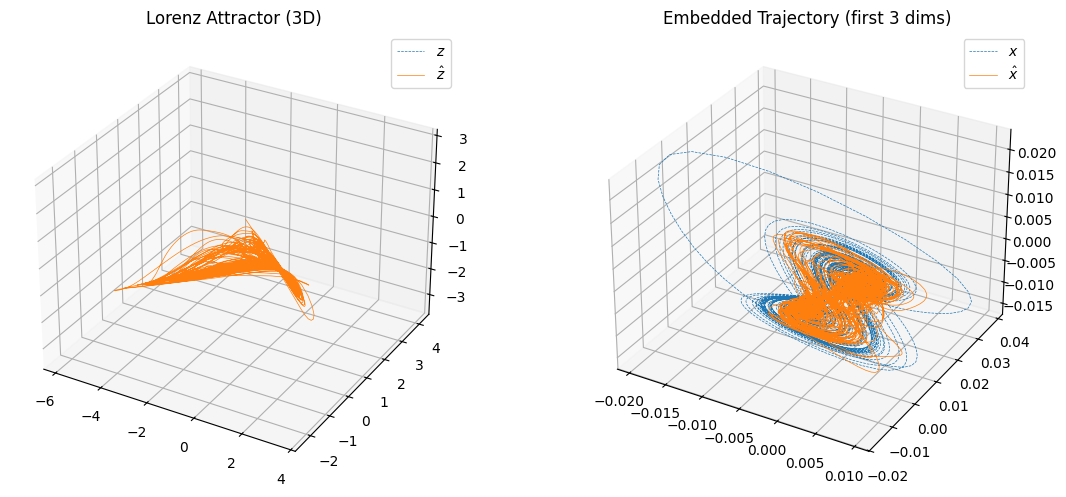

In [64]:
plot_lorenz(x=x_full, z=z_full, x_hat=x_hat_full, z_hat=z_hat_full)#/torch.linalg.norm(z_hat_full,dim=0))

In [50]:
with torch.no_grad():
    test_loss = model.compute_loss(x=x_full.to(device), x_hat=x_hat_full.to(device), mu=mu, logvar=logvar)
test_loss

{'elbo': tensor(1.7891e-06, device='mps:0'),
 'reconstruction': tensor(1.7891e-06, device='mps:0'),
 'kl': tensor(8.1913, device='mps:0')}

In [24]:
batch = next(iter(dl))
x, z_true = batch
with torch.no_grad():
    x_hat, _, _ = model(x)
x_hat.shape

RuntimeError: torch.cat(): all input tensors must be on the same device. Received cpu and mps:0

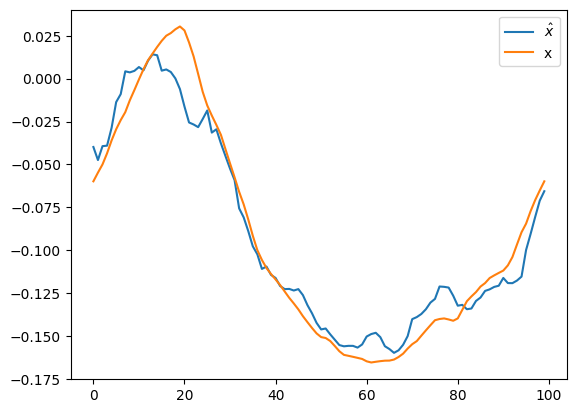

In [ ]:
plt.plot(x_hat.cpu().detach().numpy()[0,:,:].T[:,0], label=r"$\hat{x}$")
plt.plot(x.cpu().detach().numpy()[0,:,:].T[:,0], label="x")
plt.legend()

In [ ]:
x

tensor([[[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0.0558,  0.0549,  0.0532],
         [ 0.0409,  0.0409,  0.0404,  ...,  0.0393,  0.0404,  0.0409],
         ...,
         [-0.0488, -0.0546, -0.0607,  ..., -0.0385, -0.0435, -0.0488],
         [ 0.0232,  0.0275,  0.0320,  ...,  0.0149,  0.0190,  0.0232],
         [-0.1102, -0.1044, -0.0985,  ..., -0.1218, -0.1161, -0.1102]],

        [[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0.0558,  0.0549,  0.0532],
         [ 0.0409,  0.0409,  0.0404,  ...,  0.0393,  0.0404,  0.0409],
         ...,
         [-0.0488, -0.0546, -0.0607,  ..., -0.0385, -0.0435, -0.0488],
         [ 0.0232,  0.0275,  0.0320,  ...,  0.0149,  0.0190,  0.0232],
         [-0.1102, -0.1044, -0.0985,  ..., -0.1218, -0.1161, -0.1102]],

        [[-0.0598, -0.0548, -0.0500,  ..., -0.0708, -0.0652, -0.0598],
         [ 0.0532,  0.0506,  0.0471,  ...,  0